# **Assignment_2**

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

## **Helper Function**

In [2]:
# Generate a synthetic wave dataset
def generate_wave_data(num_samples, sequence_length, noise=0.1):
  # Generate random frequency components with random amplitudes signal
  x = np.linspace(0, num_samples * np.pi, num_samples)
  # Change here: Generate a single frequency instead of an array
  frequency = np.random.uniform(1, 100, 2)
  amplitudes = np.random.rand(2)
  # Change here: use frequency directly instead of frequencies[0]
  signal = (amplitudes[0] * (frequency[0] * np.cos(2 * np.pi * x))) +  (amplitudes[1] * (frequency[1] * np.cos(2 * np.pi * x)))
  # Add some noise
  noise = noise * np.random.randn(num_samples)

  noisy_signal = signal + noise
  return noisy_signal, signal

In [3]:
# Build TCN model
from tensorflow.keras import layers, models
def build_tcn_model(input_shape, kernel_size=3, num_filters=32, dilation_rates=[1, 2, 4], dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)

    #Temporal Convolutions
    x = inputs
    for dilation_rate in dilation_rates:
        x = layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,   #Allow the network to see a wider range of past data without increasing parameters.
            padding="causal",              #Ensures predictions only depend on past data
            activation="relu"
        )(x)
        x = layers.BatchNormalization()(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Fully Connected Layer
    outputs = layers.Dense(1)(x)  # Linear activation for regression

    model = models.Model(inputs, outputs)
    return model

In [4]:
# Model parameters
SEQUENCE_LENGTH = 50
INPUT_SHAPE = (SEQUENCE_LENGTH, 1)
KERNEL_SIZE = 3
NUM_FILTERS = 32
DILATION_RATES = [1, 2, 4]
DROPOUT_RATE = 0.2

# Build and compile the model
model = build_tcn_model(INPUT_SHAPE, KERNEL_SIZE, NUM_FILTERS, DILATION_RATES, DROPOUT_RATE)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,753 (26.38 KB)

 Trainable params: 6,561 (25.63 KB)

 Non-trainable params: 192 (768.00 B)

In [5]:
# Generate data
X, y = generate_wave_data(10000, SEQUENCE_LENGTH, noise=0.1)
X.shape, y.shape

((10000,), (10000,))

In [6]:
# Split into train/test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (8000, 1)
Testing data shape: (2000, 1)


In [8]:
X_train = X_train.reshape(-1, SEQUENCE_LENGTH, 1)
X_test = X_test.reshape(-1, SEQUENCE_LENGTH, 1)

##Autoencoder

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


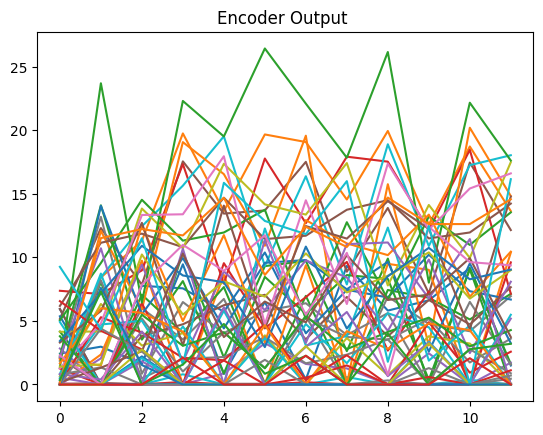

In [9]:
input_layer = Input(shape=(SEQUENCE_LENGTH, 1))

# TCN Encoder
x = Conv1D(filters=32, kernel_size=3, activation='relu', dilation_rate=1, padding='causal')(input_layer)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu', dilation_rate=2, padding='causal')(x)
encoded = MaxPooling1D(pool_size=2)(x)


encoded_model = Model(inputs=input_layer, outputs=encoded)


encoded_output = encoded_model.predict(X_test)
plt.plot(encoded_output[0])
plt.title("Encoder Output ")
plt.show()

In [10]:
# TCN Decoder
x = UpSampling1D(size=2)(encoded)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)

x = UpSampling1D(size=2)(x)
decoded = Conv1D(filters=1, kernel_size=3, activation='linear', padding='same')(x)


In [11]:
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 25, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 48, 1)          │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,881 (73.75 KB)

 Trainable params: 18,881 (73.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    X_train, y_train,
    epochs=2000,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1544.1364 - val_loss: 1567.5352
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1508.8911 - val_loss: 1568.2130
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1559.6284 - val_loss: 1569.6510
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1575.1224 - val_loss: 1569.2203
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1514.2349 - val_loss: 1568.9572
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1500.1619 - val_loss: 1568.2953
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1605.8257 - val_loss: 1568.9652
Epoch 8/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1491.6257 - val_loss: 1568.6100
Epoch 9/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1559.0116 - val_loss: 1568.6875
Epoch 10/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1595.5895 - val_loss: 1569.0942
Epoch 11/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1599.2791 - val_loss: 1568.03

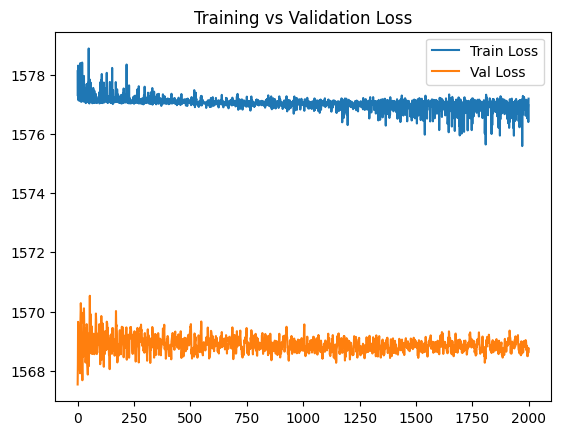

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


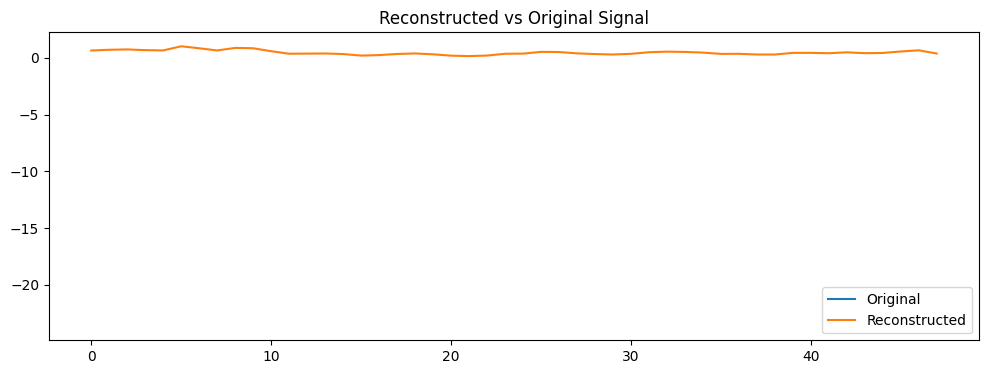

In [ ]:
reconstructed = autoencoder.predict(X_test)

# Display one example
idx = 3
plt.figure(figsize=(12, 4))
plt.plot(y_test[idx], label='Original')
plt.plot(reconstructed[idx], label='Reconstructed')
plt.legend()
plt.title("Reconstructed vs Original Signal")
plt.show()


In [ ]:
mae = mean_absolute_error(y_test[:reconstructed.shape[0]*reconstructed.shape[1]], reconstructed.flatten())
mse = mean_squared_error(y_test[:reconstructed.shape[0]*reconstructed.shape[1]], reconstructed.flatten())

mae

35.592054721893255

In [ ]:
mse


1563.4293100247867